# 1 Beginners

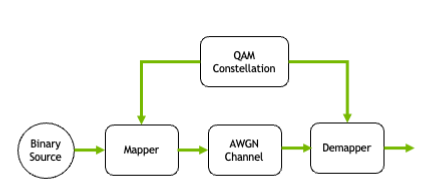

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

In [ ]:
# Constellation

NUM_BITS_PER_SYMBOL = 4 # QPSK
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

constellation.show(figsize=(7,7));

In [ ]:
# Mapper and Demapper

mapper = sn.mapping.Mapper(constellation=constellation)

# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

In [ ]:
binary_source = sn.utils.BinarySource()

awgn_channel = sn.channel.AWGN()

no = sn.utils.ebnodb2no(ebno_db=10.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

BATCH_SIZE = 64 # How many examples are processed by Sionna in parallel

bits = binary_source([BATCH_SIZE,
                      1024]) # Blocklength
print("Shape of bits: ", bits.shape)
print(bits)

x = mapper(bits)
print("Shape of x: ", x.shape)
print("x=",x)

y = awgn_channel([x, no])
print("Shape of y: ", y.shape)
print("y=",y)

llr = demapper([y, no])
print("Shape of llr: ", llr.shape)
print("llr=",llr)

In [ ]:
num_samples = 8 # how many samples shall be printed
num_symbols = int(num_samples/NUM_BITS_PER_SYMBOL)

print(f"First {num_samples} transmitted bits: {bits[0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(llr[0,:num_samples], 2)}")

In [ ]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

In [ ]:
# Task: Change the SNR or Eb/N0 to 30dB to visualize the impact on the received samples
no_1 = sn.utils.ebnodb2no(ebno_db=30.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

no_2 = sn.utils.ebnodb2no(ebno_db=10.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

no_3 = sn.utils.ebnodb2no(ebno_db=1.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

BATCH_SIZE = 64 # How many examples are processed by Sionna in parallel
bits = binary_source([BATCH_SIZE,
                      1024]) # Blocklength
x = mapper(bits)
y_1 = awgn_channel([x, no_1])
llr_1 = demapper([y_1, no_1])
y_2 = awgn_channel([x, no_2])
llr_2 = demapper([y_2, no_2])
y_3 = awgn_channel([x, no_3])
llr_3 = demapper([y_3, no_3])

plt.figure(figsize=(7,7))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.subplot(3,1,1)
plt.scatter(tf.math.real(y_1), tf.math.imag(y_1))
plt.subplot(3,1,2)
plt.scatter(tf.math.real(y_2), tf.math.imag(y_2))
plt.subplot(3,1,3)
plt.scatter(tf.math.real(y_3), tf.math.imag(y_3))
plt.tight_layout()

## 1.1 Forward Error Correction (FEC)

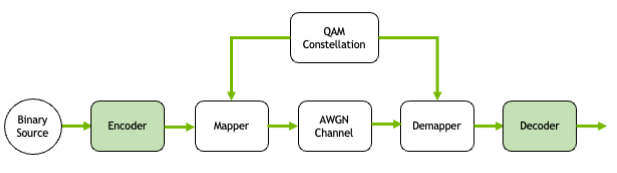

### Linear Codes

In [ ]:
# Linear Encoder

inputs = np.matrix('0 0 1') # Information Bits
print('inputs:',inputs)
gm = np.matrix('1 0 0 1 1 0; 0 1 0 0 1 1; 0 0 1 1 0 1') # Generator Matrix
print('gm:',gm)
c = tf.linalg.matmul(inputs, gm) # Codewords = Information Bits * Generator Matrix
print('c:',c)

# faster implementation of tf.math.mod(c, 2)
c_uint8 = tf.cast(c, tf.uint8)
print('c_uint8:',c_uint8)
c_bin = tf.bitwise.bitwise_and(c_uint8, tf.constant(1, tf.uint8))
print('c_bin:',c_bin)
c = tf.cast(c_bin, tf.float32)
print('c:',c)

### LDPC

In [ ]:
k = 12
n = 20

encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder, hard_out=True)

BATCH_SIZE = 1 # one codeword in parallel
u = binary_source([BATCH_SIZE, k])
print("Input bits are: \n", u.numpy())

c = encoder(u)
print("Encoded bits are: \n", c.numpy())

### BATCH_SIZE=2, num_basestations=3, num_users=4, k=15

In [ ]:
BATCH_SIZE = 2 # samples per scenario
num_basestations = 3 
num_users = 4 # users per basestation
n = 30 # codeword length per transmitted codeword
coderate = 0.5 # coderate

k = int(coderate * n) # number of info bits per codeword

# instantiate a new encoder for codewords of length n
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# the decoder must be linked to the encoder (to know the exact code parameters used for encoding)
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder,
                                    hard_out=True, # binary output or provide soft-estimates
                                    return_infobits=True, # or also return (decoded) parity bits
                                    num_iter=20, # number of decoding iterations
                                    cn_type="boxplus-phi") # also try "minsum" decoding

# draw random bits to encode
u = binary_source([BATCH_SIZE, num_basestations, num_users, k])
print("Shape of u: ", u.shape)
print('u = ', u)

# We can immediately encode u for all users, basetation and samples 
# This all happens with a single line of code
c = encoder(u)
print("Shape of c: ", c.shape)

print("Total number of processed bits: ", np.prod(c.shape))

### BATCH_SIZE=10, num_basestations=4, num_users=5, k=500

In [ ]:
BATCH_SIZE = 10 # samples per scenario
num_basestations = 4 
num_users = 5 # users per basestation
n = 1000 # codeword length per transmitted codeword
coderate = 0.5 # coderate

k = int(coderate * n) # number of info bits per codeword

# instantiate a new encoder for codewords of length n
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# the decoder must be linked to the encoder (to know the exact code parameters used for encoding)
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder,
                                    hard_out=True, # binary output or provide soft-estimates
                                    return_infobits=True, # or also return (decoded) parity bits
                                    num_iter=20, # number of decoding iterations
                                    cn_type="boxplus-phi") # also try "minsum" decoding

# draw random bits to encode
u = binary_source([BATCH_SIZE, num_basestations, num_users, k])
print("Shape of u: ", u.shape)

# We can immediately encode u for all users, basetation and samples 
# This all happens with a single line of code
c = encoder(u)
print("Shape of c: ", c.shape)

print("Total number of processed bits: ", np.prod(c.shape))

In [ ]:
k = 64
n = 128

encoder = sn.fec.polar.Polar5GEncoder(k, n)
decoder = sn.fec.polar.Polar5GDecoder(encoder,
                                      dec_type="SCL") # you can also use "SCL" 

## Plot SER (Uncoded System)

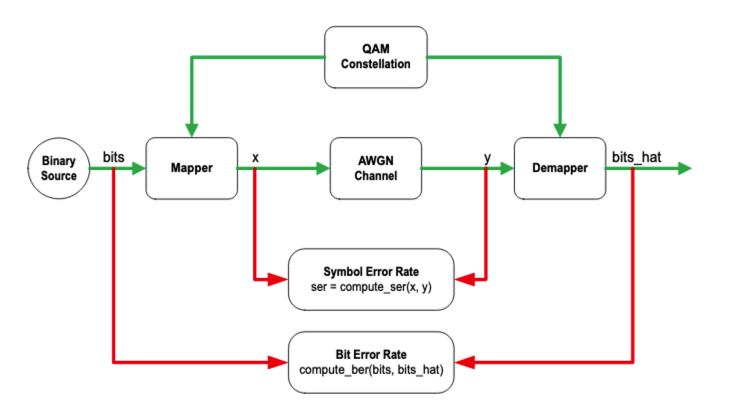

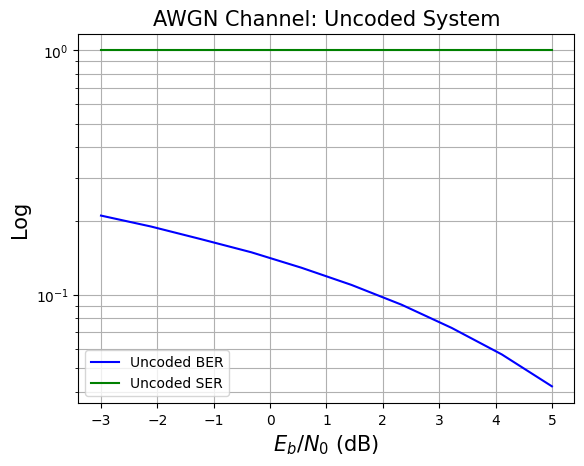

In [10]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = 1024
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()
snrs = []
bers = []
sers = []

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,10):
    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
			    
    bits = binary_source([BATCH_SIZE,BLOCK_LENGTH]) # Blocklength

    x = mapper(bits)

    y = awgn_channel([x, no])

    llr = demapper([y, no])

    bits_hat = hard_decisions(llr)

    ber = compute_ber(bits, bits_hat)

    ser = compute_ser(x, y)

    snrs += [EBN0_DB]
    bers += [ber]
    sers += [ser]

title = "AWGN Channel: Uncoded System"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Log"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers, 'b', label='Uncoded BER')
plt.semilogy(snrs, sers, 'g', label='Uncoded SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

### About sionna.utils.hard_decisions

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = 1024
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations
EBN0_DB = 1

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

bits = binary_source([BATCH_SIZE,
                    BLOCK_LENGTH]) # Blocklength
#print("Shape of bits: ", bits.shape)
#print(bits)

x = mapper(bits)
#print("Shape of x: ", x.shape)
#print("x=",x)

y = awgn_channel([x, no])
#print("Shape of y: ", y.shape)
#print("y=",y)

llr = demapper([y, no])
#print("Shape of llr: ", llr.shape)
print("llr=",llr)

bits_hat = hard_decisions(llr)
print("bits_hat=",bits_hat)

x_hat = mapper(bits_hat)

### Plot ln(x) to Explain LLR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x range
x = np.linspace(-2, 2, 101)

# Calculate the y values
y = np.log(x)

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('x')
plt.ylabel('ln(x)')
plt.title('Logarithmic function')
plt.text(x[75], y[75], y[75], color = 'r')  # Mark the point (0,1)
# Remove frame of chart
ax = plt.gca()  # Get current axis
ax.spines['right'].set_color('none')  # Set right frame's color as none
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
 
# Set the central of axis as（0，0）
ax.spines['bottom'].set_position(('data', 0))  # The bottom of the specified data setting (that is, the specified x-axis) is bound to the point 0 of the y-axis
ax.spines['left'].set_position(('data', 0))

# Show the plot
plt.show()

## Plot SRE (Coded System)

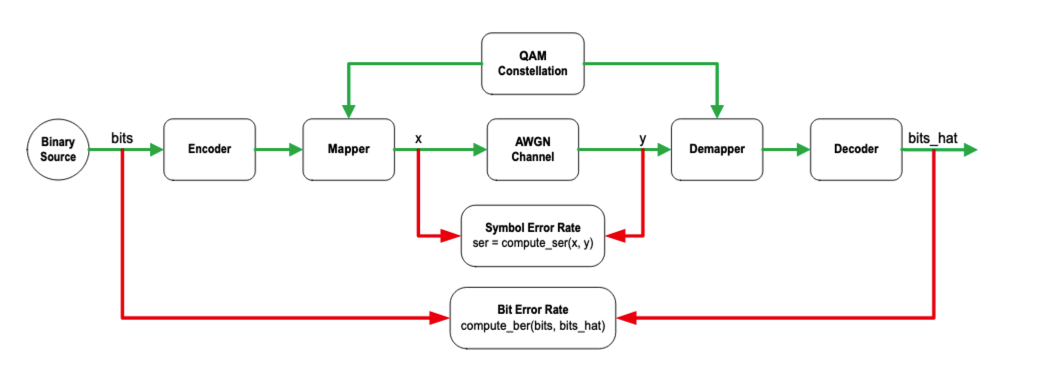

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

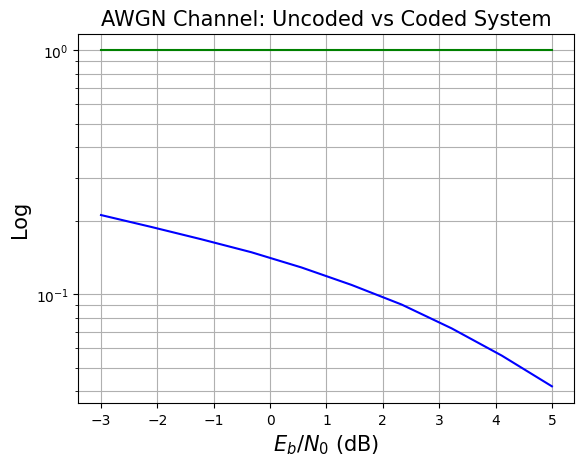

In [12]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# LDPC Encoder
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder, hard_out=True)

snrs = []
bers = []
sers = []
snrs1 = []
bers1 = []
sers1 = []

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,10):
    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
			    
    bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])

    x = mapper(bits)

    y = awgn_channel([x, no])

    llr = demapper([y, no])

    bits_hat = hard_decisions(llr)

    ber = compute_ber(bits, bits_hat)

    ser = compute_ser(x, y)

    snrs += [EBN0_DB]
    bers += [ber]
    sers += [ser]

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,10):
    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
			    
    bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])

    codewords = encoder(bits)

    x1 = mapper(codewords)
	
    y1 = awgn_channel([x1, no])
	    
    llr1 = demapper([y1, no])
		
    bits_hat1 = decoder(llr1)
		    
    ber1 = compute_ber(bits, bits_hat1)
			
    ser1 = compute_ser(x1, y1)

    snrs1 += [EBN0_DB]
    bers1 = [ber1]
    sers1 = [ser1]

title = "AWGN Channel: Uncoded vs Coded System"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Log"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers, 'b', label='Uncoded BER')
plt.semilogy(snrs, sers, 'g', label='Uncoded SER')
plt.semilogy(snrs1, bers1, 'r', label='Coded BER')
plt.semilogy(snrs1, sers1, 'y', label='Coded SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

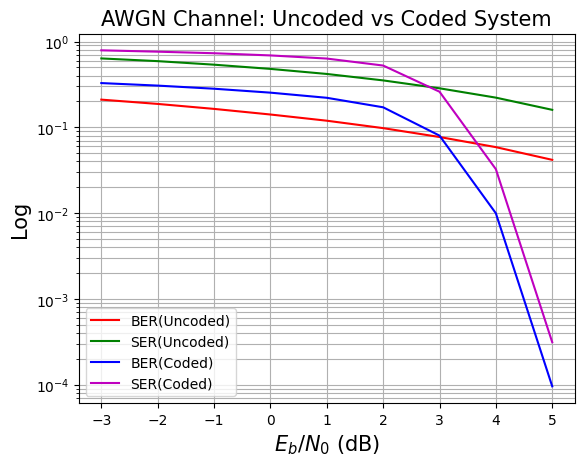

## 1.2 Part 1 Exercise
Simulate the coded bit error rate (BER) for a Polar coded and 64-QAM modulation. Assume a codeword length of n = 200 and coderate = 0.5.

### LDPC Method

In [ ]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

class UncodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, block_length):
        """
        A keras model of an uncoded transmission over the AWGN channel.

        Parameters
        ----------
        num_bits_per_symbol: int
            The number of bits per constellation symbol, e.g., 4 for QAM16.

        block_length: int
            The number of bits per transmitted message block (will be the codeword length later).

        Input
        -----
        batch_size: int
            The batch_size of the Monte-Carlo simulation.

        ebno_db: float
            The `Eb/No` value (=rate-adjusted SNR) in dB.

        Output
        ------
        (bits, llr):
            Tuple:

        bits: tf.float32
            A tensor of shape `[batch_size, block_length] of 0s and 1s
            containing the transmitted information bits.

        llr: tf.float32
            A tensor of shape `[batch_size, block_length] containing the
            received log-likelihood-ratio (LLR) values.
        """

        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    # @tf.function # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=1.0)

        bits = self.binary_source([batch_size, self.block_length]) # Blocklength set to 1024 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        return bits, llr

class CodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, n, coderate):
        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.n = n
        self.k = int(n*coderate)
        self.coderate = coderate
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)

        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)

        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.k, self.n)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    #@tf.function # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)

        bits = self.binary_source([batch_size, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        bits_hat = self.decoder(llr)
        return bits, bits_hat

@tf.function() # enables graph-mode of the following function
def run_graph(batch_size, ebno_db):
    # all code inside this function will be executed in graph mode, also calls of other functions
    print(f"Tracing run_graph for values batch_size={batch_size} and ebno_db={ebno_db}.") # print whenever this function is traced
    return model_coded_awgn(batch_size, ebno_db)

# *You can implement your code here*

n = 198
NUM_BITS_PER_SYMBOL = 6
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel
batch_size = BATCH_SIZE
CODERATE = 0.5
ebno_db = -3.0
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations

model_uncoded_awgn = UncodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, 
                                       block_length=1024)

model_coded_awgn = CodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                   n=n,
                                   coderate=CODERATE)

run_graph(batch_size, ebno_db)

ber_plots = sn.utils.PlotBER("AWGN")

# ber_plots.simulate(model_uncoded_awgn,
#                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
#                   batch_size=BATCH_SIZE,
#                   num_target_block_errors=100, # simulate until 100 block errors occured
#                   legend="Uncoded",
#                   soft_estimates=True,
#                   max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
#                   show_fig=True);

# ber_plots.simulate(model_coded_awgn,
#                    ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 15),
#                    batch_size=BATCH_SIZE,
#                    num_target_block_errors=500,
#                    legend="Coded",
#                    soft_estimates=False,
#                    max_mc_iter=15,
#                    show_fig=True,
#                    forward_keyboard_interrupt=False);

ber_plots.simulate(run_graph,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 12),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=500,
                   legend="Coded (Graph mode)",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

### Polar Codes Method

In [ ]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

class UncodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, block_length):
        """
        A keras model of an uncoded transmission over the AWGN channel.

        Parameters
        ----------
        num_bits_per_symbol: int
            The number of bits per constellation symbol, e.g., 4 for QAM16.

        block_length: int
            The number of bits per transmitted message block (will be the codeword length later).

        Input
        -----
        batch_size: int
            The batch_size of the Monte-Carlo simulation.

        ebno_db: float
            The `Eb/No` value (=rate-adjusted SNR) in dB.

        Output
        ------
        (bits, llr):
            Tuple:

        bits: tf.float32
            A tensor of shape `[batch_size, block_length] of 0s and 1s
            containing the transmitted information bits.

        llr: tf.float32
            A tensor of shape `[batch_size, block_length] containing the
            received log-likelihood-ratio (LLR) values.
        """

        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    # @tf.function # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=1.0)

        bits = self.binary_source([batch_size, self.block_length]) # Blocklength set to 1024 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        return bits, llr

class CodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, n, coderate):
        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.n = n
        self.k = int(n*coderate)
        self.coderate = coderate
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)

        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)

        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.k, self.n)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    #@tf.function # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)

        bits = self.binary_source([batch_size, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        bits_hat = self.decoder(llr)
        return bits, bits_hat

@tf.function() # enables graph-mode of the following function
def run_graph(batch_size, ebno_db):
    # all code inside this function will be executed in graph mode, also calls of other functions
    print(f"Tracing run_graph for values batch_size={batch_size} and ebno_db={ebno_db}.") # print whenever this function is traced
    return model_coded_awgn(batch_size, ebno_db)

# *You can implement your code here*

n = 198
NUM_BITS_PER_SYMBOL = 6
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel
batch_size = BATCH_SIZE
CODERATE = 0.5
ebno_db = -3.0
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations

model_uncoded_awgn = UncodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, 
                                       block_length=1024)

model_coded_awgn = CodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                   n=n,
                                   coderate=CODERATE)

run_graph(batch_size, ebno_db)

ber_plots = sn.utils.PlotBER("AWGN")

# ber_plots.simulate(model_uncoded_awgn,
#                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
#                   batch_size=BATCH_SIZE,
#                   num_target_block_errors=100, # simulate until 100 block errors occured
#                   legend="Uncoded",
#                   soft_estimates=True,
#                   max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
#                   show_fig=True);

# ber_plots.simulate(model_coded_awgn,
#                    ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 15),
#                    batch_size=BATCH_SIZE,
#                    num_target_block_errors=500,
#                    legend="Coded",
#                    soft_estimates=False,
#                    max_mc_iter=15,
#                    show_fig=True,
#                    forward_keyboard_interrupt=False);

ber_plots.simulate(run_graph,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 12),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=500,
                   legend="Coded (Graph mode)",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

## 1.5 Simple MIMO Simulation

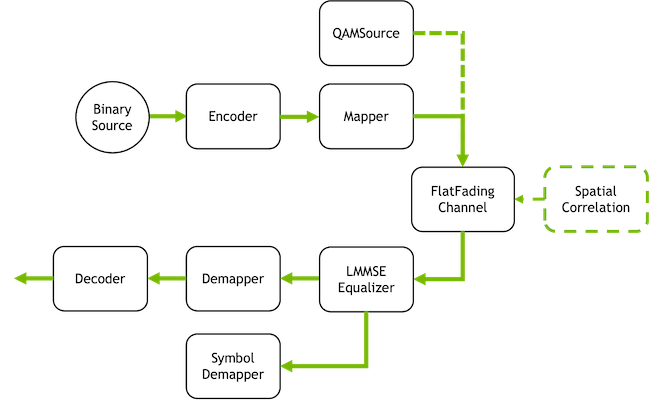

### 1.5.1 Flat-Fading Channel

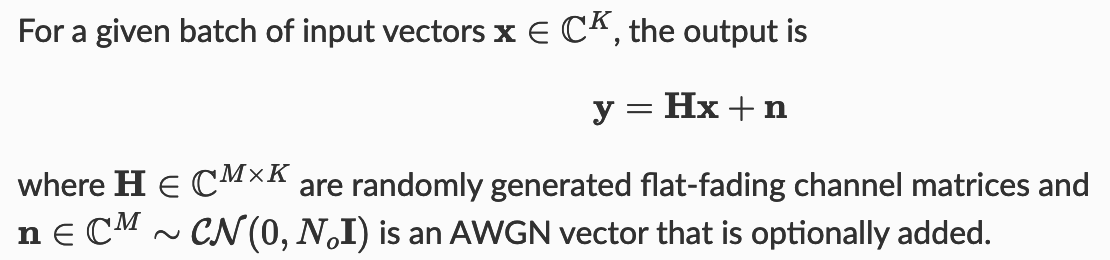

In [ ]:
### GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

### Import Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

### Simple Uncoded Transmission
num_tx_ant = 2 # Number of Transmitter Antennas
num_rx_ant = 3 # Number of Receiver Antennas
num_bits_per_symbol = 4 # 16QAM
batch_size = 4 # Parallel in 1024
qam_source = QAMSource(num_bits_per_symbol)
x = qam_source([batch_size, num_tx_ant])
print('x.shape =',x.shape) # (1024, 4)
print('x =',x)

### Create `FlatFadingChannel` to simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
channel = FlatFadingChannel(num_tx_ant, num_rx_ant, add_awgn=True, return_channel=True)
no = 0.2 # Noise variance of the channel

# y and h are the channel output and channel realizations, respectively.
y, h = channel([x, no]) # x = qam_source([batch_size, num_tx_ant]); no = 0.2
print('y.shape =',y.shape)
print('y =',y)
print('h.shape =',h.shape)
print('h =',h)

# z = h*x+0.2
# print('z =',z)

In [ ]:
import tensorflow as tf
from sionna.channel import AWGN
from sionna.utils import complex_normal
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER

def complex_normal(shape, var=1.0, dtype=tf.complex64):
    r"""Generates a tensor of complex normal random variables.

    Input
    -----
    shape : tf.shape, or list
        The desired shape.

    var : float
        The total variance., i.e., each complex dimension has
        variance ``var/2``.

    dtype: tf.complex
        The desired dtype. Defaults to `tf.complex64`.

    Output
    ------
    : ``shape``, ``dtype``
        Tensor of complex normal random variables.
    """
    # Half the variance for each dimension
    var_dim = tf.cast(var, dtype.real_dtype)/tf.cast(2, dtype.real_dtype)
    stddev = tf.sqrt(var_dim)

    # Generate complex Gaussian noise with the right variance
    xr = tf.random.normal(shape, stddev=stddev, dtype=dtype.real_dtype)
    xi = tf.random.normal(shape, stddev=stddev, dtype=dtype.real_dtype)
    x = tf.complex(xr, xi)

    return x

num_tx_ant = 2
num_rx_ant = 4
batch_size = 4
no = 0.2

qam_source = QAMSource(num_bits_per_symbol)
x = qam_source([batch_size, num_tx_ant])
print('x.shape =',x.shape)
print('x =',x)

shape = [batch_size, num_rx_ant, num_tx_ant]
h = complex_normal(shape)
print('h.shape =',h.shape)
print('h',h)

awgn_channel = sn.channel.AWGN()

x = tf.expand_dims(x, axis=-1)
print('x.shape =',x.shape)
print('x =',x)
y = tf.matmul(h, x)
print('y.shape =',y.shape)
print('y =',y)
y = tf.squeeze(y, axis=-1)
print('y.shape =',y.shape)
y = awgn_channel([y, no])
print('y.shape =',y.shape)


# 2 Experts

## 2.2 Bit_Interleaved_Coded_Modulation

In [ ]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
# Load the required Sionna components
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder, LDPCBPDecoder
from sionna.fec.interleaving import RandomInterleaver, Deinterleaver
from sionna.fec.scrambling import Scrambler, Descrambler
from sionna.fec.utils import GaussianPriorSource, load_parity_check_examples, get_exit_analytic, plot_exit_chart, plot_trajectory
from sionna.utils import BinarySource, ebnodb2no, hard_decisions
from sionna.utils.plotting import PlotBER
from sionna.channel import AWGN

# show QPSK constellation
constellation = Constellation("qam", num_bits_per_symbol=2)
constellation.show();

# generate 16QAM with Gray labeling
constellation = Constellation("qam", num_bits_per_symbol=4)
constellation.show();